In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from gauss_filter import Gaussian2D
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

In [11]:
df = pd.read_csv('video Data Export-ivt.tsv', sep='\t')

In [12]:
df.loc[(df['Eye movement type'] == 'Fixation') | (df['Eye movement type'] == 'Saccade')]


,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Client area position X (DACSpx),Client area position Y (DACSpx),Viewport position X,Viewport position Y,Viewport width,Viewport height,Full page width,Full page height,Mouse position X,Mouse position Y
11,244,1495655,Eye Tracker,video,2/24/2022,Jelle,Recording1,2/22/2022,2/22/2022,17:18:50.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,253,1495663,Eye Tracker,video,2/24/2022,Jelle,Recording1,2/22/2022,2/22/2022,17:18:50.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,261,1495672,Eye Tracker,video,2/24/2022,Jelle,Recording1,2/22/2022,2/22/2022,17:18:50.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,269,1495680,Eye Tracker,video,2/24/2022,Jelle,Recording1,2/22/2022,2/22/2022,17:18:50.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,278,1495688,Eye Tracker,video,2/24/2022,Jelle,Recording1,2/22/2022,2/22/2022,17:18:50.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19883,88922,2650572,Eye Tracker,video,2/24/2022,Jelle2,Recording2,2/22/2022,2/22/2022,17:36:36.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19884,88930,2650580,Eye Tracker,video,2/24/2022,Jelle2,Recording2,2/22/2022,2/22/2022,17:36:36.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19885,88938,2650589,Eye Tracker,video,2/24/2022,Jelle2,Recording2,2/22/2022,2/22/2022,17:36:36.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19886,88940,2650591,NaN,video,2/24/2022,Jelle2,Recording2,2/22/2022,2/22/2022,17:36:36.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# df = df[['Participant', 'Interval', 'Event_type', 'Start', 'Duration', 'FixationPointX', 'FixationPointY', 'Average_pupil_size']]

# indexNames = df[ (df['Gaze point X'] < 0) | (df['Gaze point X'] > 1) | (df['Gaze point Y'] < 0) | (df['Gaze point Y'] > 1) | (df['Participant name'] == 'Jelle2')].index
# df = df.drop(indexNames , inplace=True)

In [14]:
df['X'] = df['Gaze point X']
df['Y'] = df['Gaze point Y']

xMin = df['X'].min()
xMax = df['X'].max()

yMin = df['Y'].min()
yMax = df['Y'].max()

print(f"X min: {xMin}, X max: {xMax}, Y min: {yMin}, X max: {yMax}")



X min: -1.0, X max: 1530.0, Y min: 25.0, X max: 1142.0


In [15]:
df['Recording resolution height'][0]

1080

In [62]:
def iter_convolve(img, iterations):
    gaussian = (1 / 16.0) * np.array([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]])
    
    for _ in range(iterations):
        img = convolve2d(img, gaussian, 'same', boundary = 'fill', fillvalue = 0)

    return img

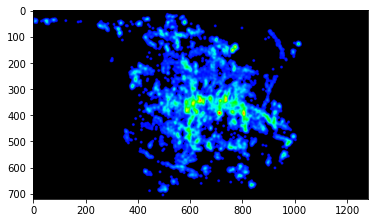

In [66]:
data = df.loc[(df['Recording timestamp'] > 0) & (df['Recording timestamp'] < 70000)]

w = df['Recording resolution width'][0]
h = df['Recording resolution height'][0]

X = np.array(data['X'].values).astype(np.uint16)
Y = np.array(data['Y'].values).astype(np.uint16)

heatmap, xedges, yedges = np.histogram2d(X, Y, bins=(1280, 720), range=[[0, w], [0, h]])
heatmap *= 255
heatmap = heatmap.astype(np.uint8).T

heatmap = iter_convolve(heatmap, 20)


# heatmap = Gaussian2D(heatmap, sigma=2)
heatmap = heatmap.astype(np.uint8)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HSV)
heatmap[np.where((heatmap==[0, 0, 255]).all(axis=2))] = [0, 0, 0]


plt.imshow(heatmap)